# The Geotools workbook
This is a ipython notebook meant to hold several useful tools for everyday geoscience work. Most of these items solve probelms I've had in the past, deal with curiosities I've had, or are just things I felt the software I had available to me didn't implement very well.

#### Importing all packages required for the different functions

In [156]:
import numpy as np
import bruges as b
import matplotlib.pyplot as plt
from matplotlib import gridspec 
#from las import LASReader ## Now using welly, need to fix the Liner and Fei Backus number workflow
import welly
from tkinter import filedialog #Python 3.X simple GUI
from scipy import signal
import bruges
import pandas as pd
import math #this needs to be changes so that math is not required. Should be using numpy only

%matplotlib inline

### Liner & Fei Backus thickness determination via the 'Backus Number.' 

This function uses the work of Liner & Fei to calculate the Backus average 
of the input curves at varying layer thicknesses. It then plots the orginal
curves and the average curves. A second plot is used to illustrate the maximum 
bed thickness which will maintain all primaries and scattering reflection 
information for selected frequencies ($B <1/3$) as well as maximum bed thickness
which will maintain main primary reflectios only ($B <2$) and is suitable for migration
velocity analysis, etc.

$$B = \frac{L'f}{V_{Smin}}$$

$\textbf{Variables:}\\
    B = \text{Backus number}\\
    L' = \text{Backus layer thickness}\\
    f = \text{frequency}\\
    Vs min = \text{The minimum shear velocity after backus averaging}$

References:

[https://library.seg.org/doi/abs/10.1190/1.2723204]


In [13]:
def lfBackus(lb,freqs):
    lasPath = filedialog.askopenfilename()
    
    lasFile = LASReader(lasPath,null_subs=np.nan)
    
    print('LAS info:')
    print( 'Start: '+ str(lasFile.start))
    print('Stop: ' + str(lasFile.stop))
    print('Step: ' + str(lasFile.step))
    print('NULL: ' + str(lasFile.null))
        
    depth = lasFile.data['DEPT']
    dts = lasFile.data['DTS']
    dtc = lasFile.data['DTC']
    rhob = lasFile.data['RHOB']
    dz = lasFile.step
    
    for i in np.arange(len(dts)):
        if dts[i]<0:
            dts[i] = np.nan
            if dtc[i]<0:
                dtc[i] = np.nan
                if rhob[i]<0:
                    rhob[i] = np.nan
                    
    vs = 1e6/(3.28084*dts)
    vp = 1e6/(3.28084*dtc)
         
    vsMin = np.array(np.zeros(len(lb)))
    plt.figure(figsize=(15,10))
    for i in np.arange(len(lb)):
        plot = b.rockphysics.backus(vp,vs,rhob,lb[i],dz)
        plt.subplot(1, len(lb), i+1)
        plt.plot(vp,depth,'k',alpha=0.25)
        plt.plot(vs,depth,'k',alpha=0.25)
        plt.plot(plot[0], depth,'b',alpha=0.75)
        plt.plot(plot[1],depth,'g',alpha=0.75)
        plt.gca().invert_yaxis()
        plt.title( '%d m Backus layer' % lb[i] )
        plt.grid()
        vsMin[i]=np.min(plot[1])
        plt.xlim(1000,6000)
        plt.legend()
    plt.tight_layout()    
    
    f, axarr = plt.subplots(1,2)
    axarr[1].set_ylim(0,3)
    axarr[1].set_xlim(0,np.max(lb))
    for i in np.arange(len(freqs)):
        axarr[0].plot(lb,vsMin,'o',lb,vsMin,'g--')
        axarr[0].set_title('$L$\'(m) vs Vs $min$')
        axarr[0].set_xlabel('$L$\' (backus length)',fontsize=10)
        axarr[0].set_ylabel('Vs $min$')
        axarr[1].plot(lb,(np.ones(len(lb))/3),'r--')
        axarr[1].plot(lb,(np.ones(len(lb))*2),'b--')
        axarr[1].set_title('Frequency ($Hz$) vs $L$\'')
        axarr[1].set_xlabel('$L$\' (backus length)')
        axarr[1].set_ylabel('$L$\' Backus Number')
        axarr[1].plot(lb,(freqs[i]*lb)/vsMin,label='%s Hz' % freqs[i])
        axarr[1].legend(loc='upper left',fontsize='large')
        plt.tight_layout()
    

In [27]:
lb = np.array([1,3,5,7,10,20,30,50,80,120])
freqs = np.array([10,20,30,40,50,60,70,80])
lfBackus(lb,freqs)

NameError: name 'LASReader' is not defined

### Series of zero-offset synthetics
This will produce a series of zero-offset synthetics of different frequencies and display them side by side along with the AI and RC model. Currently uses a zero phase Ricker wavelet by default.

The function is defined below:

In [6]:
def zeroOffset(mSamples,nTraces,numLayers,layerThicknesses,vp,rho,frequencies):
    # Create the 2D impedance model (TWT for now)----------------------------------
            
    layerTopTime = np.cumsum(layerThicknesses,dtype=int) # cumulative sum of the thickness array to be used for top positions when building the AI grid
    layerTopTime = np.insert(layerTopTime,0,0) # insert a 0 at the beginning of the array to make the makeModel function simpler
    layerTopTime = layerTopTime[0:numLayers] # remove the last np.cumsum value since the way we build the 
    
    rockGrid = np.zeros((mSamples, nTraces)) # create an empty (zero populated) array
    
    # Build the AI model
    ai = vp*rho
    ai = ai / 1e6 # re-scale
    
    # FUNCTIONS--------------------------------------------------------------------
    # Function to create a simple layered model in TWT
    def makeModel(mSamples, nTraces,layerTopTime):
        for j in np.arange(nTraces):
            for i in np.arange(mSamples):
                for k in np.arange(len(layerTopTime)):
                    if i>=layerTopTime[k]:
                        rockGrid[i][j] = ai[k]
        return rockGrid # this makes sure the rockGrid variable is actually returned and stored since
                        # variables in python functions exist only within the function unless otherwise specified
    
    # Function to create synthetic 
    def makeSynth(f):
        synth = np.zeros(( mSamples-1, nTraces)) # Create an array of dimenions [m-1,n] samples. -1 to match the m-1 sample output 
                                                 # from convolve with 'same' flag
        wavelet = signal.ricker(512,1e3/(4.*f))
        wavelet = wavelet / max(wavelet)   # normalize
        for k in range(nTraces):
            synth[:,k] = signal.convolve(rc[:,k], wavelet,'same') # flag 'same' in order to keep the vector sizes the same. 
                                                                  # This is because after convolution the result is a vector of the combined length of the inputs.
        return synth
    
    #------------------------------------------------------------------------------       
    
    aiModel = makeModel(mSamples,nTraces,layerTopTime)
    
    # compute the reflection coefficients.
    upper = aiModel[:-1][:] # every n-1 sample
    lower = aiModel[1:][:] #every n sample
    rc = (lower - upper) / (lower + upper) #calculates the reflection coefficients
    maxrc = abs(np.amax(rc))
    
    # Accept user input for center frequencies (non-limited list length)
    plt.figure(figsize = (20, 10))
    for i in np.arange(len(frequencies)):
        thisPlot = makeSynth(frequencies[i])
        plt.subplot(1, len(frequencies)+2, i+1)
        plt.imshow(thisPlot, cmap='seismic', vmax=1.5*maxrc, vmin=-1.5*maxrc,) #2*maxrc to make a softer color scale
        plt.title( '%d Hz wavelet' % frequencies[i] )
        plt.grid()
        plt.axis('tight')
        plt.colorbar()
        plt.tight_layout()
        
    plt.subplot(1,len(frequencies)+2,len(frequencies)+1)
    plt.imshow(aiModel,cmap='viridis'); plt.colorbar();plt.title('Normalized AI model');plt.axis('tight')
    plt.subplot(1,len(frequencies)+2,len(frequencies)+2)
    plt.imshow(rc,cmap='plasma'); plt.colorbar();plt.title('Reflection Coefficients');plt.axis('tight') 
    
#     plt.figure(figsize=(7,15))
#     for i in np.arange(len(frequencies)):
#         seis = makeSynth(frequencies[i])
#         rcTrace = rc[:,1]
#         seisTrace = seis[:,1]
#         plt.plot(rcTrace,np.arange(len(rcTrace)),'k-',alpha=0.5,linewidth=2.0)
#         plt.xlim(-0.5,0.5)
#         plt.plot(seisTrace,np.arange(len(seisTrace)),label='%s Hz' % frequencies[i])
#         plt.xlim(-0.5,0.5)
#         plt.ylim(350,500)
#         #plt.title('1 ms coals, ' + str(layerThicknesses[2]) + ' ms of separation')
#         plt.ylabel('TWT Time (ms)')
#         plt.xlabel('Normalized amplitude')
#         plt.legend()
#     plt.gca().invert_yaxis()
    
   # plt.show()
#    plt.savefig('1msCoals'+str(layerThicknesses[2])+'msSeparation.png',bbox_inches='tight')
#        plt.subplot(122)
#        plt.plot(aiModel,cmap='viridis')

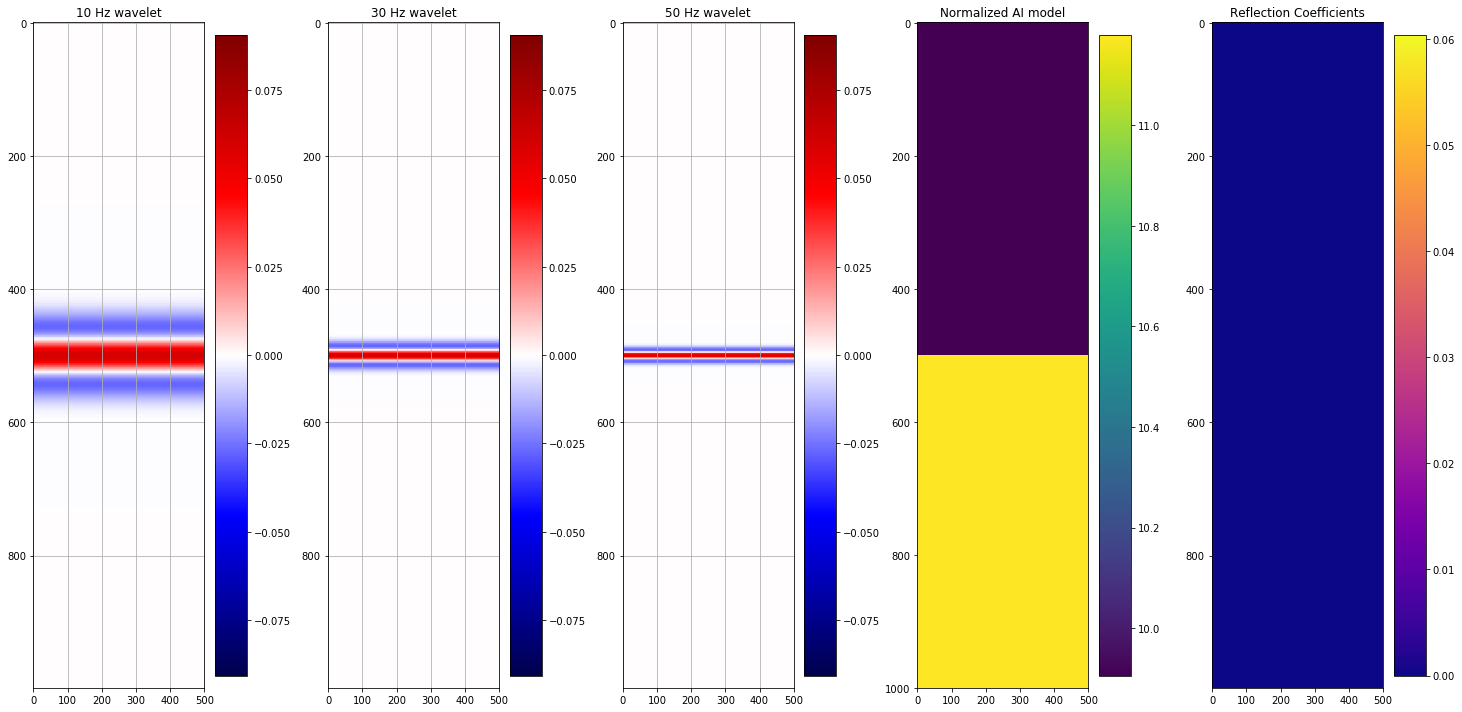

In [7]:
mSamples,nTraces,numLayers = 1000,500,2
layerThicknesses = np.array([500.,500.])
vp = np.array([3900.,4300.])
rho = np.array([2540.,2600.])
frequencies = np.array([10,30,50])
zeroOffset(mSamples,nTraces,numLayers,layerThicknesses,vp,rho,frequencies)

### Wedge Model from Matt Hall of agilegeoscience

In [168]:
def wedge():
    length, depth = 40, 100
    model = 1 + np.tri(depth, length, -depth//3)
    model[:depth//3,:] = 0
    rocks = np.array([[4000, 2650], [4200, 2800], [4000, 2650]])
    earth = np.take(rocks, model.astype(int), axis=0)
    imp = np.apply_along_axis(np.product, -1, earth)
    rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])
    w = bruges.filters.ricker(duration=0.100, dt=0.001, f=30)
    synthWedge = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0, arr=rc)
    plt.figure(figsize=(20,10))
    
    plt.subplot(111)
    plt.imshow(synthWedge, cmap="seismic", aspect=0.2)
    plt.xlabel('Wedge Thickness',fontsize=20)
    plt.ylabel('TWT (ms)',fontsize=20)
    plt.title('Seismic Reflection Wedge Model',fontsize = 20)
    plt.colorbar(plt.imshow(synthWedge, cmap="seismic", aspect=0.2),fraction=0.02, pad=0.04)

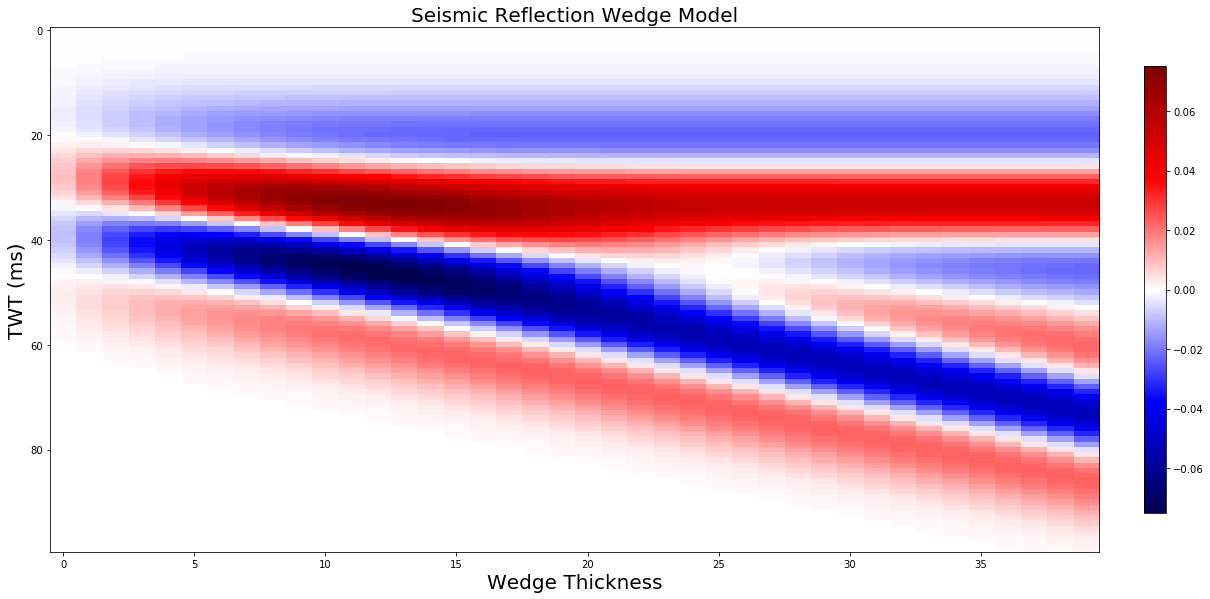

In [169]:
wedge()

### Knott-Zoeppritz matrix representation (from Castanga and Backus 1993) vectorized

Below is the vectorized matrix representation of the Knott-Zoeppritz equations such that $Q = P^{-1} R$

While accurate, these equations do not provide a very intuitive physical understanding of how reflection varies with rock properties. This will be expanded upon later with the various approximations to the Zoeppritz equations.

##### From Castagna and Backus 1993: 

For an interface between two infinite elastic half-spaces, there are sixteen reflection and transmission coefficients. In the Aki and Richards notation, the coefficients are represented by two letters (e.g. $\grave{P}\acute{S}$). The first letter indicates the type of incident wave and the second letter represents the type of derived wave. The acute acent indicates an upgoing wave while a downgoing wave has a grave accent. Thus, $\grave{P}\acute{S}$ is the downgoing P-wave to the upgoing S-wave coefficient. With this notation, the scattering matrix is:
    
  $$ 
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $$
  
  $$Where:$$ 

 $$ 
   P=
  \left[ {\begin{array}{cccc}
   -sin\ \theta_1 & -cos\ \phi_1 & sin\ \theta_2 & cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   -\rho V_{p1} (1-2sin^2\ \phi_1) & \rho_1 V_{s1} sin\ 2\phi_1 & \rho_2 V_{p2}(1-2 sin^2\ \phi_2) & -\rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right]   
  $$
  
  $$and$$
  
  $$
     R=
  \left[ {\begin{array}{cccc}
   sin\ \theta_1 & cos\ \phi_1 & -sin\ \theta_2 & -cos\ \phi_2 \\
   cos\ \theta_1 & -sin\ \phi_1 & cos\ \theta_2 & -sin\ \phi_2 \\
   2 \rho_1 V_{s1} sin\ \phi_1 cos\ \theta_1 & \rho_1 V_{s1}(1 - 2sin^2 \phi_1) & 2\rho_2 V_{s2} sin\ \phi_2 cos\ \theta_2 & \rho_2 V_{s2} (1-2sin^2\ \phi_2)\\ 
   \rho V_{p1} (1-2sin^2\ \phi_1) & -\rho_1 V_{s1} sin\ 2\phi_1 & -\rho_2 V_{p2}(1-2 sin^2\ \phi_2) & \rho_2V_{p2} sin2\ \phi_2
  \end{array} } \right] 
  $$

Parameters are defined here


In [83]:
theta
vp,vs,rho = ([[2438,2600],[1006,1700],[2250,1850]])

vs1=vs[0]; vs2=vs[1]    
vp1=vp[0]; vp2 = vp[1]    
rho1=rho[0]; rho2=rho[1] 
theta1 = range(91)

Zoeppritz scattering matrix defined below:

In [106]:
def zoeppritz(vp,vs,rho,theta):

    theta1 = np.radians(theta).astype(complex)
    vs1=vs[0]; vs2=vs[1]    
    vp1=vp[0]; vp2 = vp[1]    
    rho1=rho[0]; rho2=rho[1]
    p = np.sin(theta1) / vp1 # ray parameter p
    theta2 = np.arcsin(p*vp2)
    phi1= np.arcsin(p*vs1)
    phi2 = np.arcsin(p*vs2)

    P = np.array([[-np.sin(theta1), -np.cos(phi1), np.sin(theta2), np.cos(phi2)],
              [np.cos(theta1), -np.sin(theta1), np.cos(theta2), -np.sin(phi2)], 
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2), 
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [-rho1*vp1*(1-2*np.sin(theta1)**2), rho1*vs1*np.sin(2*phi1),rho2*vp2*(1-2*np.sin(phi2)**2),-rho2*vs2*np.sin(2*phi2)]])

    R = np.array([[np.sin(theta1), np.cos(phi1), -np.sin(theta2), -np.cos(phi2)],
              [np.cos(theta1), -np.sin(phi1), np.cos(theta2), -np.sin(phi2)],
              [2*rho1*vs1*np.sin(phi1)*np.cos(theta1), rho1*vs1*(1-2*np.sin(phi1)**2),
               2*rho2*vs2*np.sin(phi2)*np.cos(theta2), rho2*vs2*(1-2*np.sin(phi2)**2)],
              [rho1*vp1*(1-2*np.sin(theta1)**2), -rho1*vs1*np.sin(2*phi1),-rho2*vp2*(1-2*np.sin(phi2)**2),rho2*vs2*np.sin(2*phi2)]])

    Q = np.linalg.inv(P)*R
    
    return Q

In [143]:
theta = 50

print('The real components of the scattering matrix for a wave incident at ' 
      + str(theta) + ' degrees: ' + '\n'+ '\n'+ str(np.real(zoeppritz(vp,vs,rho,theta))))


The real components of the scattering matrix for a wave incident at 50 degrees: 

[[ -4.47510767e-01   8.21740403e-01  -1.88379243e-07   1.92018451e-07]
 [ -1.19384261e-01   1.80871854e-01   7.38130820e-08  -6.04537381e-08]
 [  3.96388932e+05   1.34469044e+05   2.44952536e-01   2.35494587e-01]
 [ -2.72916291e+04  -9.63345380e+04  -4.75859078e-01  -7.02543713e-01]]


Recall:
  $
   Q=
  \left[ {\begin{array}{cccc}
   \grave{P}\acute{P} & \grave{S}\acute{P} & \acute{P}\acute{P} & \acute{S}\acute{P} \\
   \grave{P}\acute{S} & \grave{S}\acute{S} & \acute{P}\acute{S} & \acute{S}\acute{S} \\
   \grave{P}\grave{P} & \grave{S}\grave{P} & \acute{P}\grave{P} & \acute{S}\grave{P} \\   
   \grave{P}\grave{S} & \grave{S}\grave{S} & \acute{P}\grave{S} & \acute{S}\grave{S} \\       
  \end{array} } \right]
     = P^{-1}R
  $

### Zoeppritz Rpp and Rps from Aki Richards, 1980 derivation (vectorized)
#### Restated in Lu et al., 2015 *Joint PP and PS AVA seismic inverson using the exact Zoeppritz equations*
https://doi.org/10.1190/geo2014-0490.1

This allows for an array to be passed to a zoeppritz solution, rather than a single value for theta which we must then iterate over.

In [93]:
#Full Zoeppritz Rpp and Rps from Aki and Richards 1980 derivation
def zoeRppRss(vp,vs,rho,thetaMax):    
    theta1 = np.radians(np.arange(thetaMax)).astype(complex)
    p = np.sin(theta1) / vp1  # Ray parameter
    theta2 = np.arcsin(p * vp2)
    phi1 = np.arcsin(p * vs1)  # Reflected S
    phi2 = np.arcsin(p * vs2)  # Transmitted S

    a = rho2 * (1 - 2 * np.sin(phi2)**2.) - rho1 * (1 - 2 * np.sin(phi1)**2.)
    b = rho2 * (1 - 2 * np.sin(phi2)**2.) + 2 * rho1 * np.sin(phi1)**2.
    c = rho1 * (1 - 2 * np.sin(phi1)**2.) + 2 * rho2 * np.sin(phi2)**2.
    d = 2 * (rho2 * vs2**2 - rho1 * vs1**2)

    E = (b * np.cos(theta1) / vp1) + (c * np.cos(theta2) / vp2)
    F = (b * np.cos(phi1) / vs1) + (c * np.cos(phi2) / vs2)
    G = a - d * np.cos(theta1)/vp1 * np.cos(phi2)/vs2
    H = a - d * np.cos(theta2)/vp2 * np.cos(phi1)/vs1

    D = E*F + G*H*p**2

    Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp1) - c*(np.cos(theta2)/vp2)) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp1)*(np.cos(phi2)/vs2)))

    Rps = (1/(vs1*D)) * (-2*(np.cos(theta1)/vp1) * (a*b + c*d*((np.cos(theta2)*np.cos(phi2))/(vp2*vs2))*p*vp1))
    
    return Rpp, Rps


# Approximations to the Zoeppritz Equations

##### From Shuey, 1985:

Although the four [Zoeppritz] equations can be solved for the four unknowns, they do not give an intuitive understanding for how the reflection amplitudes vary with the rock properties involved (density, velocity etc.)

#### Shuey Approximation and Equation (2-term and 3-term)

$$\textbf{Two-term Approximation:}$$

$$R(\theta ) \approx R(0) + G \sin^2 \theta$$

$$where$$

$$R(0) = \frac{1}{2} \left ( \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} + \frac{\Delta \rho}{\rho} \right )\ and\ G = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}} - 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P}} \left ( \frac{\Delta \rho}{\rho} + 2 \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}  \right )$$

$$\textbf{Three-term Equation:}$$

$$R(\theta ) = R(0) + G \sin^2 \theta + F ( \tan^2 \theta - \sin^2 \theta )$$

$$where$$ 

$$F = \frac{1}{2}\frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}$$

From Avseth et al., 2006 *Quantitative seismic interpretation*

In [138]:
def shuey(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    
    #2-term approximation
    R0 = 0.5*(dvp/vpav + drho/rhoav)
    G = 0.5*(dvp/vpav) - 2*(vsav**2/vpav**2)*(drho/rhoav + 2*(dvs/vsav))
    
    #3-term shuey equation
    F = 0.5*(dvp/vpav)
    
    shuey2 = R0 + G*np.sin(theta)**2
    shuey3 = R0 + G*np.sin(theta)**2 + F*(np.tan(theta)**2 - np.sin(theta)**2)
    
    return shuey2, shuey3


#### Aki-Richards

From Avesth et al., 2006 *Quantitative seismic interpretation*

$$R(\theta) = W - X \sin^2 \theta + Y \frac{1}{\cos^2 \theta_\mathrm{avg}} - Z \sin^2 \theta $$

$$W = \frac{1}{2} \frac{\Delta \rho}{\rho}\ ,\
X = 2 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta \rho}{\rho}\ ,\
Y = \frac{1}{2} \frac{\Delta V_\mathrm{P}}{V_\mathrm{P}}\ ,\
Z = 4 \frac{V^2_\mathrm{S}}{V^2_\mathrm{P1}} \frac{\Delta V_\mathrm{S}}{V_\mathrm{S}}$$

$$\text{Where the delta expressions are, for example:}$$

$$\frac{\Delta \rho}{\rho} = \frac{\rho_2 - \rho_1}{(\rho_1 + \rho_2)/2}$$


An important parameter here which is not present in the other approximations is the $\theta_{avg}$ parameter. It is the mean of the incident and transmission angles, often approximated as the incidence angle, but calcualted exactly in this implementation. 

##### Define parameters for a two layer model

In [148]:
thetaMax = 91
vp,vs,rho = ([[2438,2600],[1006,1700],[2250,1850]])

In [159]:
def akiRich(vp,vs,rho,thetaMax):
    
    dvp = vp[1]-vp[0]
    dvs = vs[1]-vs[0]
    drho = rho[1]-rho[0]
    vpav = np.mean(vp)
    vsav = np.mean(vs)
    rhoav = np.mean(rho)
    theta = np.radians(np.arange(thetaMax)).astype(complex)
    thetaTransmitted = np.arcsin(vp2/vp1*np.sin(theta))
    thetaAvg = (theta+thetaTransmitted)/2
    
    W = 0.5*(drho/rhoav)
    X = 2*(vsav/vp1)**2 * (drho/rhoav)
    Y = 0.5*(dvp/vpav)
    Z = 4*(vsav/vp1)**2 * (dvs/vsav)
    
    akiRich = W - X * np.sin(theta)**2 + Y*(1/np.cos(thetaAvg)**2) - Z*np.sin(theta)**2
    
    return akiRich

##### Plotting happens here

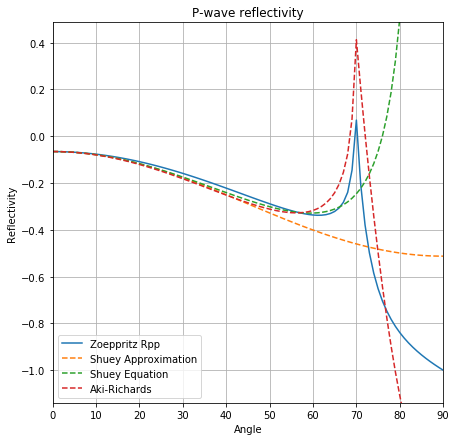

In [162]:
Rpp,Rps = zoeRppRss(vp,vs,rho,thetaMax)
shuey2,shuey3 = shuey(vp,vs,rho,thetaMax)
aki = akiRich(vp,vs,rho,thetaMax)

plt.figure(figsize=(7,7))

plt.plot(np.real(Rpp),label = 'Zoeppritz Rpp')
#plt.plot(np.real(Rps), label = 'Zoeppritz Rps')
plt.plot(np.real(shuey2), '--', label = 'Shuey Approximation')
plt.plot(np.real(shuey3), '--', label = 'Shuey Equation')
plt.plot(np.real(aki),'--', label = 'Aki-Richards')
plt.xlim(0,thetaMax-1)
plt.ylim(np.min(np.real(Rpp))-(np.std(np.real(Rpp))*0.5),np.max(np.real(Rpp))+(np.std(np.real(Rpp)))*1.5)
#plt.ylim(-1,1)
plt.xlabel('Angle')
plt.ylabel('Reflectivity')
plt.title('P-wave reflectivity')
plt.legend()
plt.grid()

### Script to generate a zero-offset synthetic from a 3-layer wedge model.

Created by:    Wes Hamlyn  
Create Date:   19-Aug-2014  
Last Mod:      1-Nov-2014  

This script is provided without warranty of any kind.

DEFINE MODELING PARAMETERS HERE

In [116]:
#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [4000.0, 3800.0, 4100.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0]  # S-wave velocity (m/s)
rho_mod= [2.6, 2.45, 2.6]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 60.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)


#   Ricker Wavelet Parameters
wvlt_length= 0.128
wvlt_cfreq = 30.0
wvlt_phase = 0.0


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

#   Plot Parameters
min_plot_time = 0.09
max_plot_time = 0.18
excursion = 2

##### Function Definitions

In [117]:
def plot_vawig(axhdl, data, t, excursion, highlight=None):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        if i==highlight:
            lw = 2
        else:
            lw = 0.5

        axhdl.plot(tbuf, t, color='black', linewidth=lw)

        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def calc_rc(vp_mod, rho_mod):
    '''
    rc_int = calc_rc(vp_mod, rho_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    
    rc_int = []
    for i in range(0, nint):
        buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
        buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
        buf3 = buf1/buf2
        rc_int.append(buf3)
    
    return rc_int
    

def calc_times(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int



def digitize_model(rc_int, t_int, t):
    '''
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''   
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc

##### Computations

In [118]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)

#   Generate ricker wavelet
wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)


syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    #print("finished step %i" % (model))
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

##### Plotting everything together

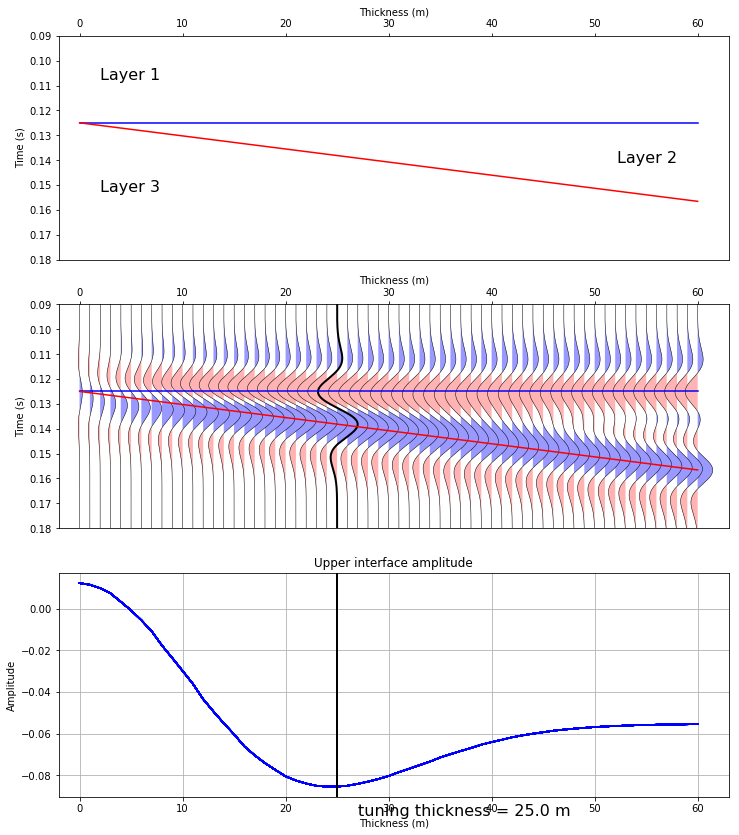

In [163]:
[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12, 14))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=1.5)
ax0.plot(lyr_times[:,1], color='red', lw=1.5)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=16)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.,
        'Layer 2',
        fontsize=16,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=16)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=1.5)
ax1.plot(lyr_times[:,1], color='red', lw=1.5)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=2)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace + 2,
        plt.ylim()[0] * 1.1,
        'tuning thickness = {0} m'.format(str(tuning_thickness)),
        fontsize=16)

#plt.savefig('figure_1.png')
plt.show()


### Python script to generate a synthetic angle gather from a 3-layer property model to examine pre-stack tuning effects.

Created by:    Wes Hamlyn  
Create Date:   19-Aug-2014  
Last Mod:      5-Feb-2015  
               -addition of bandpass wavelet

This script is provided without warranty of any kind.


In [164]:
#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [4016.0, 4219.0, 4255.0]  # P-wave velocity (m/s)
vs_mod = [2123.0, 2544.0, 2262.0]  # S-wave velocity (m/s)
rho_mod= [2.615, 2.479, 2.621]         # Density (g/cc)

thickness = 25.0  # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 50.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.1
max_plot_time = 0.16
excursion = 2

##### Functions defined here

In [165]:
def plot_vawig(axhdl, data, t, excursion):
    
    [ntrc, nsamp] = data.shape

    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i,:] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    '''
    Calculate a trapezoidal bandpass wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)
    
    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
    
    nsamp = int(wvlt_length/dt + 1)
    
    
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq*0.0
    pspec = freq*0.0
    
    # Calculate slope and y-int for low frequency ramp
    M1 = 1/(f2-f1)
    b1 = -M1*f1
    
    # Calculate slop and y-int for high frequency ramp
    M2 = -1/(f4-f3)
    b2 = -M2*f4
    
    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)
    
    # Build LF ramp
    idx = np.nonzero((np.abs(freq)>=f1) & (np.abs(freq)<f2))
    filt[idx] = M1*np.abs(freq)[idx]+b1
    
    # Build central filter flat
    idx = np.nonzero((np.abs(freq)>=f2) & (np.abs(freq)<=f3))
    filt[idx] = 1.0
    
    # Build HF ramp
    idx = np.nonzero((np.abs(freq)>f3) & (np.abs(freq)<=f4))
    filt[idx] = M2*np.abs(freq)[idx]+b2
    
    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2*np.exp(np.zeros(filt2.shape)*1j)
    
    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt/np.max(np.abs(wvlt)) # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length*0.5, wvlt_length*0.5, nsamp)
    
    
    # Apply phase rotation if desired
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt
    
    

def calc_times(z_int, vp_mod):
    '''
    Calculate two-way travel time through a layered model
    
    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)
    
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            zdiff = zdiff*2.0   # multiply by 2 for two-way traveltimes
            tbuf = zdiff/vp_mod[i] + t_int[i-1]
            tbuf = tbuf
            t_int.append(tbuf)
    
    return t_int



def digitize_model(rc_int, t_int, t):
    '''
    Sample a simple layered reflectivity model
    
    Usage:
    ------
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc
    

def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    import math
    
    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)
    
    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1), \
            rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')
    
    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),\
            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]\
        ], dtype='float')
    
    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);
    
    return R


def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    
    Usage:
    ------
        p = ray_param(v, theta)
    
    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)
    
    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    '''
    
    import math
    
    # Cast inputs to floats
    theta = float(theta)
    v = float(v)
    
    p = math.sin(math.radians(theta))/v # ray parameter calculation
    
    return p


##### Computations occur here

In [166]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
#print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0] + dz_app)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    #print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])


#   Copy convoved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])



#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

#print('\n\n')
#print '  Method       NI         GRAD'
#print '---------------------------------'
#print ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1])
#print ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1])


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):] = vp_mod[2]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):] = vs_mod[2]

rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):] = rho_mod[2]


##### Plotting happens here

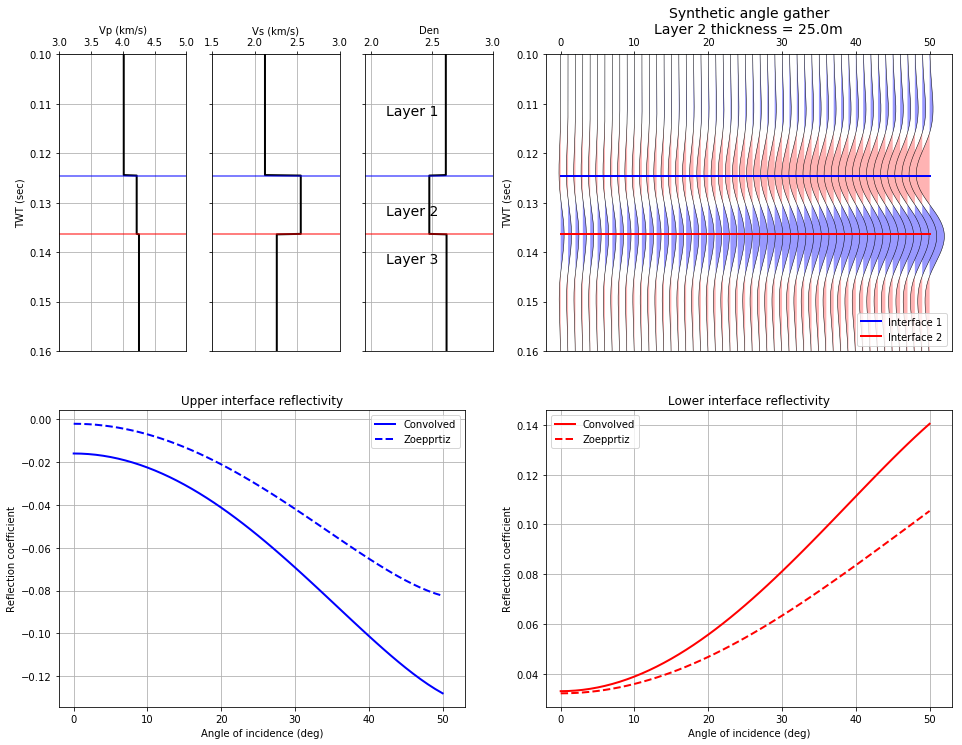

In [167]:
#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(261)
l_vp_dig, = ax0a.plot(vp_dig/1000, t, 'k', lw=2)
ax0a.set_ylim((min_plot_time,max_plot_time))
ax0a.set_xlim(3., 5.)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(262)
l_vs_dig, = ax0b.plot(vs_dig/1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.set_xlim((1.5, 3.))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(263)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.set_xlim((1.95, 3.))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0c.grid()

plt.text(2.55,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Layer 2',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=14,
        horizontalalignment='right')

#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(222)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
ax1.set_ylim((min_plot_time,max_plot_time))
l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)

plt.legend([l_int1,l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')


#   Plot Zoeppritz and convolved reflectivity curves    
ax2 = fig.add_subplot(2,2,3)

l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
l_rc1, = ax2.plot( rc_zoep_pp[:,0], '--', color='blue', lw=2)

ax2.set_xlim((-excursion, ntrc+excursion))
ax2.grid()
ax2.set_xlabel('Angle of incidence (deg)')
ax2.set_ylabel('Reflection coefficient')
ax2.set_title('Upper interface reflectivity')
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax3 = fig.add_subplot(2,2,4)
l_syn2, = ax3.plot(line2, color='red', linewidth=2)
l_rc2, = ax3.plot( rc_zoep_pp[:,1], '--', color='red', lw=2)
ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)')
ax3.set_ylabel('Reflection coefficient')
ax3.set_title('Lower interface reflectivity')
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)


#   Save the plot
plt.savefig('ThinBedTuningEffect_AVO.png',bbox_inches = 'tight')

#   Display the plot
plt.show()
